In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.show()

import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showandtell'
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name,
                                      feature_name=None)
else:
  image_model = None

predictor = melt.Predictor(model_dir)

model_dir2 = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.rnn.finetune.later'
#predictor2 = melt.Predictor(model_dir2)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.2.0-rc0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


ENCODE_UNK 1


image_model feature_name is None will get PreLogits
image_feature: Tensor("InceptionResnetV2/Logits/Dropout/Identity:0", shape=(?, 1536), dtype=float32)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/Reshape:0", shape=(?, 98304), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 13.0977888107


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showandtell/model.ckpt-73.2-300000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showandtell/model.ckpt-73.2-300000 duration: 12.2104110718


In [ ]:
def predict(image_path, predictor, length_normalization_factor=1., gen_feature=True, num_show=1):
  img = melt.read_image(image_path)
  if gen_feature:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]
  #print(feature)
  timer = gezi.Timer()
  graph = predictor.graph
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        ], 
                                        feed_dict= {
                                          graph.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          graph.get_collection('feed')[0] : feature,
                                          graph.get_collection('beam_search_input_feed')[0] : input_feed,
                                          graph.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=length_normalization_factor)


  for i, beam in enumerate(beams):
    print(i, beam.words, ids2text.ids2text(beam.words), math.exp(beam.score))

    # Plot images with attention weights
    words = beam.words    
    print(beam.logprobs)
    print(predictor.inference(graph.get_collection('greedy_log_probs_list')[0],  {graph.get_collection('feed')[0] : feature}))
    print(predictor.inference(graph.get_collection('text_score')[0],  {graph.get_collection('feed')[0] : feature}))
    print(predictor.inference(graph.get_collection('beam_text_score')[0],  {graph.get_collection('feed')[0] : feature}))
    text = gezi.pad(list(beam.words)[:-1], 100)
    print(predictor.inference('score', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  
    print(predictor.inference('exact_score', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  
    print(predictor.inference('exact_prob', {graph.get_collection('rfeed')[0]: [text], graph.get_collection('feed')[0] : feature}))  


image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:afdad6b12bd9b45eb65675ff90e896f805271896


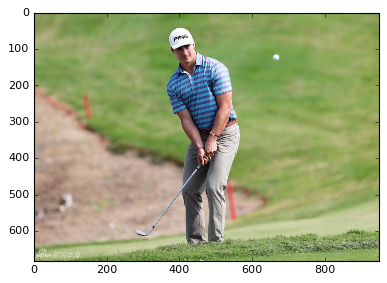

0 [10, 44, 18, 3, 265, 1, 14, 2, 111, 5, 53, 257, 9] 一个/双手/拿/着/球杆/的/男人/在/草地/上/打/高尔夫球/</S> 0.751433997149
[-0.5401203, -1.2065936, -0.02683362, -0.0032814487, -0.089906499, -0.0032270283, -0.34183365, -0.41321546, -1.0348252, -0.012349803, -0.035619926, -0.0069141421, -0.000313948]
[[-0.5401203  -0.85445648 -0.05399372 -0.07640119 -0.42666772 -0.3111437
  -1.28771317 -0.01725917 -0.09169119 -0.00608129 -0.00219723]]
[ 0.71646237]
[[ 0.75143403  0.71646273  0.65401083]]
[[ 0.75143403]]
[[ 0.75143403]]
[[ 0.75143403]]
1 [10, 43, 94, 1, 14, 2, 363, 5, 53, 257, 9] 一个/戴着/帽子/的/男人/在/草坪/上/打/高尔夫球/</S> 0.716462710913
[-0.5401203, -0.85445321, -0.053993609, -0.076400533, -0.42666879, -0.31114465, -1.2877104, -0.017259168, -0.091691077, -0.0060811732, -0.0021972342]
[[-0.5401203  -0.85445648 -0.05399372 -0.07640119 -0.42666772 -0.3111437
  -1.28771317 -0.01725917 -0.09169119 -0.00608129 -0.00219723]]
[ 0.71646237]
[[ 0.75143403  0.71646273  0.65401083]]
[[ 0.71646267]]
[[ 0.71646267]]
[[ 0.71646267

In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  image_name = image_name.strip()
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'
  image_path = os.path.join(image_dir, image_name)
  
  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    continue
    
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)